<a href="https://colab.research.google.com/github/HyeongseokKim/My_codes/blob/main/%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
pip install -U finance-datareader

In [71]:
import FinanceDataReader as fdr

In [72]:
fdr.StockListing('KRX')
df_samsung=fdr.DataReader('005930','2017-01-01','2020-12-31')


In [73]:
raw_data = (df_samsung['Close'] - df_samsung['Close'].mean()) / df_samsung['Close'].std()

In [74]:
raw_data

Date
2017-01-02   -1.901042
2017-01-03   -1.846211
2017-01-04   -1.892384
2017-01-05   -1.978959
2017-01-06   -1.886613
                ...   
2020-12-23    3.553140
2020-12-24    4.115873
2020-12-28    4.245735
2020-12-29    4.188019
2020-12-30    4.577603
Name: Close, Length: 981, dtype: float64

In [75]:
data=raw_data.to_numpy()

In [76]:
import torch
print(torch.__version__)

2.0.1+cu118


In [77]:
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
data.shape

(981,)

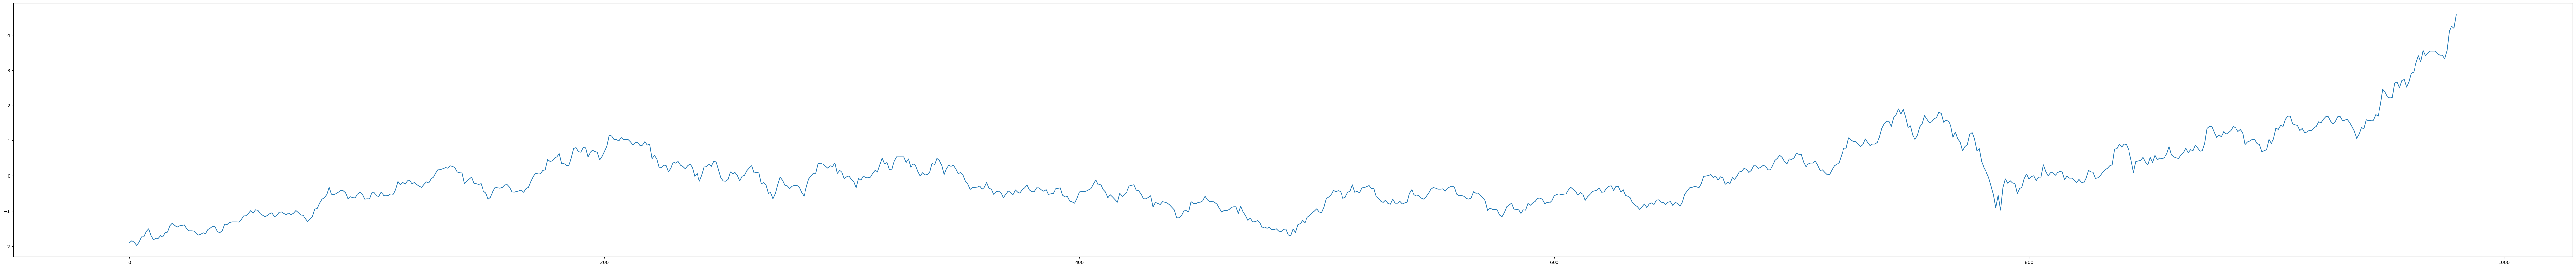

In [80]:
plt.figure(figsize=[100, 10])
plt.plot(np.arange(0, 981), data)
plt.show()

In [81]:
x_sin = np.array([[[data[i+j]] for j in range(7)] for i in range(len(data)-8)])
y_sin = np.array([[data[i+7]] for i in range(len(data)-8)])
x_sin.shape, y_sin.shape

((973, 7, 1), (973, 1))

In [82]:
train_idx = int(len(x_sin) * 0.7) # 70% 데이터까지의 인덱스

X_train = x_sin[:train_idx]
y_train = y_sin[:train_idx]
X_test = x_sin[train_idx:]
y_test = y_sin[train_idx:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(681, 7, 1) (292, 7, 1)
(681, 1) (292, 1)


In [87]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x.reshape(-1, 7, 1))
        self.y = torch.Tensor(y)

    def __getitem__(self, idx):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [88]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [94]:
class SamsungLSTM(nn.Module):
    def __init__(self):
        super(SamsungLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=7, num_layers=1, batch_first=True)
        self.fc = nn.Linear(7, 1)
        return

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])

        return output

In [121]:
model = SamsungLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.15)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [122]:
epochs = 50

for epoch in range(1, epochs+1):
    train_loss = []
    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.08124] Val Loss : [0.72528]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.01423] Val Loss : [0.73049]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.01234] Val Loss : [0.63651]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.01249] Val Loss : [0.59618]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.01122] Val Loss : [0.59019]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.01133] Val Loss : [0.57787]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.01130] Val Loss : [0.56732]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.01118] Val Loss : [0.55751]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.01100] Val Loss : [0.56703]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01094] Val Loss : [0.56325]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.01115] Val Loss : [0.57007]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.01129] Val Loss : [0.56604]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.01158] Val Loss : [0.56749]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.01109] Val Loss : [0.56751]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.01088] Val Loss : [0.56892]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.01120] Val Loss : [0.56774]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.01125] Val Loss : [0.56693]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.01083] Val Loss : [0.56693]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.01079] Val Loss : [0.56766]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.01074] Val Loss : [0.56791]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.01107] Val Loss : [0.56835]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.01102] Val Loss : [0.56854]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.01091] Val Loss : [0.56842]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.01070] Val Loss : [0.56845]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.01103] Val Loss : [0.56845]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.01080] Val Loss : [0.56854]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.01097] Val Loss : [0.56853]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.01076] Val Loss : [0.56852]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.01077] Val Loss : [0.56854]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.01073] Val Loss : [0.56856]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.01106] Val Loss : [0.56855]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.01088] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.01101] Val Loss : [0.56858]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.01089] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.01083] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.01120] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.01111] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.01089] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.01086] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.01097] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.01106] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.01083] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.01080] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.01112] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.01073] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.01102] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.01102] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.01070] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.01103] Val Loss : [0.56857]


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.01069] Val Loss : [0.56857]


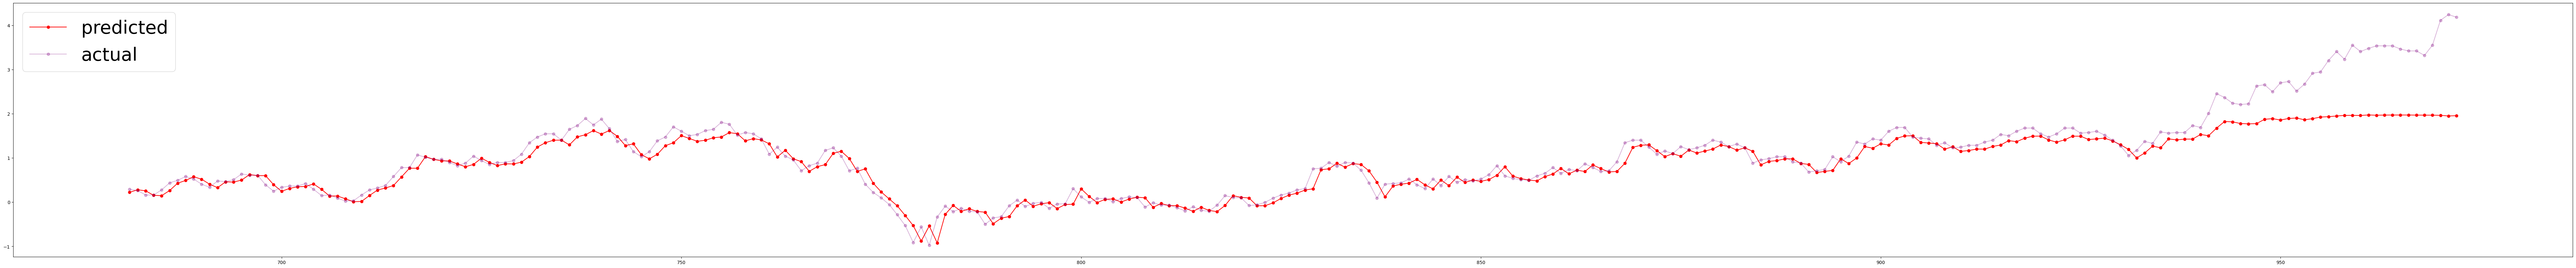

In [123]:
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()